## Mask R-CNN - Inspect Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
"""
Based on the work of Waleed Abdulla (Matterport)
Modified by github.com/GustavZ
"""

import os
import sys
import numpy as np
import tensorflow as tf
from tensorflow.tools.graph_transforms import TransformGraph
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from keras import backend as K

# All new operations will be in test mode from now on.
K.set_learning_phase(0)

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

# Model  Directory 
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
DEFAULT_WEIGHTS = os.path.join(ROOT_DIR, "mobile_mask_rcnn_coco.h5")

import mmrcnn.model as modellib

/home/ivb/.conda/envs/mobile_mask_rcnn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ivb/.conda/envs/mobile_mask_rcnn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ivb/.conda/envs/mobile_mask_rcnn/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ivb/.conda/envs/mobile_mask_

## Configurations

In [2]:
# MS COCO Dataset
import coco
config = coco.CocoConfig()
COCO_DIR = os.path.join(ROOT_DIR,"data/coco")

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    TRAIN_BN = False

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       mobilenetv1
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]


## Notebook Preferences

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
#DEVICE = "/cpu:0"
DEVICE = "/gpu:0"

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"
#TEST_MODE = "training"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Model

In [6]:
# Local path to trained h5 weights file
MODEL_NAME = 'mask_rcnn_512_cocoperson_0396' # TODO: enter value here
H5_MODEL_PATH = os.path.join(MODEL_DIR, MODEL_NAME+".h5") # TODO: enter value here

In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode=TEST_MODE, model_dir=MODEL_DIR,config=config)

# Set path to model weights
weights_path = DEFAULT_WEIGHTS
#weights_path = model.find_last()[1]

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /home/ivb/Repos/Mobile_Mask_RCNN/mobile_mask_rcnn_coco.h5


## Prepare and Export Model

In [8]:
# name of the pb file we want to output
MODEL_NAME = 'mask_rcnn_512_cocoperson_0396' # TODO: enter value here

# Chose whether to quantize the graph
QUANTIZE = False

In [9]:
# Get keras model and save
model_keras= model.keras_model


# Create output layer with customized names
num_output = 7
pred_node_names = ["detections", "mrcnn_class", "mrcnn_bbox", "mrcnn_mask", "rois", "rpn_class", "rpn_bbox"]
pred_node_names = ["output_" + name for name in pred_node_names]
pred = [tf.identity(model_keras.outputs[i], name = pred_node_names[i])for i in range(num_output)]

# Get the object detection graph
sess = K.get_session()
if QUANTIZE:
    # Transformations
    transforms = ["quantize_weights", "quantize_nodes"]
    transformed_graph_def = TransformGraph(sess.graph.as_graph_def(), [], pred_node_names, transforms)
    constant_graph = graph_util.convert_variables_to_constants(sess, transformed_graph_def, pred_node_names)
    PB_MODEL_PATH = os.path.join(MODEL_DIR, MODEL_NAME+'_quantized'+'.pb') 
else:
    constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), pred_node_names)
    PB_MODEL_PATH = os.path.join(MODEL_DIR, MODEL_NAME+'.pb') 

INFO:tensorflow:Froze 217 variables.


INFO:tensorflow:Froze 217 variables.


Converted 217 variables to const ops.


In [10]:
pred_node_names

['output_detections',
 'output_mrcnn_class',
 'output_mrcnn_bbox',
 'output_mrcnn_mask',
 'output_rois',
 'output_rpn_class',
 'output_rpn_bbox']

In [11]:
# Write Output pb File
graph_io.write_graph(constant_graph, "/", PB_MODEL_PATH, as_text=False)

# Output Info
print('{} ops in the frozen graph.'.format(len(constant_graph.node)))
print('saved the freezed graph (ready for inference) at: ', PB_MODEL_PATH)

1644 ops in the frozen graph.
saved the freezed graph (ready for inference) at:  /home/ivb/Repos/Mobile_Mask_RCNN/logs/mask_rcnn_512_cocoperson_0396.pb


In [12]:
for node in constant_graph.node:
    print(node.op)
    if node.op == "FusedBatchNorm":
        print(node)
        break

Placeholder
Placeholder
Placeholder
Const
Identity
Conv2D
Const
Identity
Const
Identity
Const
Identity
Const
Identity
Const
Add
Rsqrt
Mul
Mul
Mul
Sub
Add
Relu
Const
Minimum
Const
Identity
DepthwiseConv2dNative
Const
Identity
Const
Identity
Const
Identity
Const
Identity
Const
Add
Rsqrt
Mul
Mul
Mul
Sub
Add
Relu
Const
Minimum
Const
Identity
Conv2D
Const
Identity
Const
Identity
Const
Identity
Const
Identity
Const
Add
Rsqrt
Mul
Mul
Mul
Sub
Add
Relu
Const
Minimum
Const
Identity
DepthwiseConv2dNative
Const
Identity
Const
Identity
Const
Identity
Const
Identity
Const
Add
Rsqrt
Mul
Mul
Mul
Sub
Add
Relu
Const
Minimum
Const
Identity
Conv2D
Const
Identity
Const
Identity
Const
Identity
Const
Identity
Const
Add
Rsqrt
Mul
Mul
Mul
Sub
Add
Relu
Const
Minimum
Const
Identity
DepthwiseConv2dNative
Const
Identity
Const
Identity
Const
Identity
Const
Identity
Const
Add
Rsqrt
Mul
Mul
Mul
Sub
Add
Relu
Const
Minimum
Const
Identity
Conv2D
Const
Identity
Const
Identity
Const
Identity
Const
Identity
Const
Add
Rsqrt

In [12]:
model_keras.outputs

[<tf.Tensor 'mrcnn_detection/Reshape_1:0' shape=(1, 100, 6) dtype=float32>,
 <tf.Tensor 'mrcnn_class/Reshape_1:0' shape=(?, 100, 81) dtype=float32>,
 <tf.Tensor 'mrcnn_bbox/Reshape:0' shape=(?, 100, 81, 4) dtype=float32>,
 <tf.Tensor 'mrcnn_mask/Reshape_1:0' shape=(?, 100, 28, 28, 81) dtype=float32>,
 <tf.Tensor 'ROI/packed_2:0' shape=(1, ?, ?) dtype=float32>,
 <tf.Tensor 'rpn_class/concat:0' shape=(?, ?, 2) dtype=float32>,
 <tf.Tensor 'rpn_bbox/concat:0' shape=(?, ?, 4) dtype=float32>]

In [13]:
model_keras.inputs

[<tf.Tensor 'input_image:0' shape=(?, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'input_image_meta:0' shape=(?, 93) dtype=float32>,
 <tf.Tensor 'input_anchors:0' shape=(?, ?, 4) dtype=float32>]

## Inference Model
Now, we can load the model from the pb file and then use it to infere

In [14]:
import cv2
import matplotlib.pyplot as plt
from mmrcnn.utils import resize_image
from mmrcnn.model import compose_image_meta, mold_image, compute_backbone_shapes

In [15]:
image = cv2.imread("/datasets/NKBVS_data/converted/2019-01-31-15-53-26_kia_velo_gps_time_stereo_left/img_000000.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [16]:
image_resized, window, scale, padding, crop = resize_image(image, 384, 640)

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-BoldOblique.ttf) oblique normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Buhid' (NotoSansBuhid-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Norasi' (Norasi-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Chilanka' (Chilanka-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu' (Ubuntu-MI.ttf) italic normal medium normal>) = 11.145
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Vai' (NotoSansVai-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu' (Ubuntu-BI.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Lycian' (NotoSansLycian-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tlwg Typist' (TlwgTypist-Oblique.ttf) oblique normal 400 normal>)

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Phoenician' (NotoSansPhoenician-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kinnari' (Kinnari-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Coptic' (NotoSansCoptic-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Chakma' (NotoSansChakma-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif' (NotoSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'MathJax_SansSerif' (MathJax_SansSerif-Bold.otf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Thai' (NotoSansThai-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans 

DEBUG:matplotlib.font_manager:findfont: score(<Font 'OpenDyslexic' (OpenDyslexic-Regular.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Lepcha' (NotoSansLepcha-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Mono' (NotoSansMono-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Buginese' (NotoSansBuginese-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Display' (NotoSansDisplay-BoldItalic.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Serif Myanmar' (NotoSerifMyanmar-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Tagbanwa' (NotoSansTagbanwa-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Loma' (Loma.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Uroob' (Uroob.ttf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tiresias Infofont Z' (tiresias_infofontz_italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Canadian Aboriginal' (NotoSansCanadianAboriginal-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Loma' (Loma-BoldOblique.ttf) oblique normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lohit Devanagari' (Lohit-Devanagari.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Gubbi' (Gubbi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Osage' (NotoSansOsage-Regular.ttf) normal normal regular normal>) =

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Saurashtra' (NotoSansSaurashtra-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Waree' (Waree-BoldOblique.ttf) oblique normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tibetan Machine Uni' (TibetanMachineUni.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Oriya' (NotoSansOriya-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Norasi' (Norasi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Likhan' (LikhanNormal.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Tagalog' (NotoSansTagalog-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'padmaa' (padmaa-Medium-0.5.ttf) normal normal normal nor

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Kalapi' (Kalapi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Umpush' (Umpush-Oblique.ttf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Meera' (Meera.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Arabic' (NotoSansArabic-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Lohit Gurmukhi' (Lohit-Gurmukhi.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Ubuntu Mono' (UbuntuMono-R.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Tiresias Signfont' (tiresias_signfont_italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotl

DEBUG:matplotlib.font_manager:findfont: score(<Font 'FreeSerif' (FreeSerifBoldItalic.ttf) italic normal bold normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Abyssinica SIL' (AbyssinicaSIL-R.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Ol Chiki' (NotoSansOlChiki-Regular.ttf) normal normal regular normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Nastaliq Urdu' (NotoNastaliqUrdu-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Bengali' (NotoSansBengali-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Noto Sans Cham' (NotoSansCham-Bold.ttf) normal normal bold normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'KacstQurn' (KacstQurn.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'MathJax_Main' (MathJax_Main-Ital

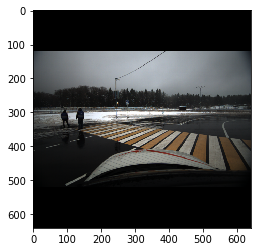

In [17]:
plt.imshow(image_resized)

In [18]:
sess_config = tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)
sess = tf.Session(config=sess_config)

In [19]:
# DOES NOT WORK YET (gustavz)
# NOW IT WORKS!!! (ivbelkin)

import cv2 
from mmrcnn import utils

utils.set_cuda_visible_devices(config.GPU_COUNT)
with tf.device(DEVICE):
    tf.global_variables_initializer().run(session=sess)
    output_graph_def = tf.GraphDef()
    with open(PB_MODEL_PATH, "rb") as f:
        output_graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(output_graph_def, name="")

    image_resized, window, scale, padding, crop = resize_image(image, 384, 640)
    image_meta = compose_image_meta(image_id=1, original_image_shape=image.shape, 
                                    image_shape=image_resized.shape, window=window, 
                                    scale=scale, active_class_ids=list(range(81)))
    image_resized = np.expand_dims(image_resized,0)
    image_meta = np.expand_dims(image_meta,0)
    image_molded = mold_image(image_resized, config)
    image_shape = image_molded[0].shape

    backbone_shapes = compute_backbone_shapes(config, image_shape)
    a = utils.generate_pyramid_anchors(
            config.RPN_ANCHOR_SCALES,
            config.RPN_ANCHOR_RATIOS,
            backbone_shapes,
            config.BACKBONE_STRIDES,
            config.RPN_ANCHOR_STRIDE)
    anchors = utils.norm_boxes(a, image_shape[:2])
    anchors = np.broadcast_to(anchors, (config.BATCH_SIZE,) + anchors.shape)

    graph = tf.get_default_graph()
    input_image = graph.get_tensor_by_name("input_image:0")
    input_image_meta = graph.get_tensor_by_name("input_image_meta:0")
    input_anchors = graph.get_tensor_by_name("input_anchors:0")
    mrcnn_mask = graph.get_tensor_by_name("output_mrcnn_mask:0")

    #[detections, mrcnn_class, mrcnn_bbox, mrcnn_mask,rois, rpn_class, rpn_bbox]
    feed = {input_image:image_resized, input_image_meta:image_meta, input_anchors: anchors}
    result = sess.run(mrcnn_mask, feed_dict = feed)
    print(result.shape)

(1, 100, 28, 28, 81)


In [20]:
%%timeit
result = sess.run(mrcnn_mask, feed_dict=feed)

50.3 ms ± 12.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
